<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Car-Mountain-Example" data-toc-modified-id="Car-Mountain-Example-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Car Mountain Example</a></span><ul class="toc-item"><li><span><a href="#Pure-Randomness" data-toc-modified-id="Pure-Randomness-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Pure Randomness</a></span></li><li><span><a href="#Intelligent-Symstem" data-toc-modified-id="Intelligent-Symstem-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Intelligent Symstem</a></span></li><li><span><a href="#Random-Search" data-toc-modified-id="Random-Search-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Random Search</a></span></li><li><span><a href="#Q-Learning:-Tabular-Method" data-toc-modified-id="Q-Learning:-Tabular-Method-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Q-Learning: Tabular Method</a></span><ul class="toc-item"><li><span><a href="#Limits-and-Bins" data-toc-modified-id="Limits-and-Bins-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Limits and Bins</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Functions</a></span></li></ul></li><li><span><a href="#RBF-NNs-&amp;-Q-Learning" data-toc-modified-id="RBF-NNs-&amp;-Q-Learning-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>RBF NNs &amp; Q-Learning</a></span><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-2.5.1"><span class="toc-item-num">2.5.1&nbsp;&nbsp;</span>Functions</a></span></li></ul></li></ul></li></ul></div>

# Car Mountain Example

The main idea of this notebook is to interact with the `car_mountain` from [Open AI Gym](https://gym.openai.com/) and treat different algorithms for this problem.

In [1]:
#Loading the required libreries
import gym
import numpy as np
import itertools
import math
import pandas as pd
import random
import io
import re
import base64
import os
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement, permutations


from gym import wrappers
from IPython.display import HTML
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import FeatureUnion
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D

## Functions

This section has all the function that I will use in the notebook.

In [2]:
#Genera un expand_grid para hacer validacion cruzada
def expand_grid(*itrs):
   product = list(itertools.product(*itrs))
   return pd.DataFrame({'Var{}'.format(i+1):[x[i] for x in product] for i in range(len(itrs))})

In [3]:
def plot_running_avg(total_rewards):
    n = len(total_rewards)
    running_avg = []
    for idx in range(1,n):
        running_avg.append(total_rewards[max(0,idx-100):idx].mean())
    plt.plot(running_avg)
    plt.title('MOVING AVERAGE')
    plt.show()

## Car Mountain Example

This section covers the `car_mountain` example.

In [4]:
#My envorinement
game = 'Car Mountain'
my_env = gym.make('MountainCar-v0')

In [5]:
#Reset the game, the car in this case
obs = my_env.reset()

In [6]:
#See the action space: we can take 3 actions, nothing, left, right
my_env.action_space

Discrete(3)

### Pure Randomness

Here we do 1000 iterations and average the result just picking an action between 0 and 1 randomly. As we can see, choicing random actions it is impossible to win the game (always reach the maximum steps allowed).

In [10]:
#Exercise: Determine how many steps, on average, are taken, when
#actions are randomly sampled
steps_array = []
for i in range(1000):
    my_env.reset()
    done = False
    steps = 0
    while not done:
        my_env.render()
        obs, rew, done, _ = my_env.step(action=my_env.action_space.sample())
        steps += 1
    steps_array.append(steps)
my_env.close()
print('AVERAGE OF STEPS:', np.mean(steps_array))
print('STD OF STEPS:', np.round(np.std(steps_array), 2))

AVERAGE OF STEPS: 200.0
STD OF STEPS: 0.0


### Intelligent Symstem

This section uses an inteligent system in order to determine waht action to take. It's simple:

1. If the car has positive velocity and before had postive velocity: move it to the right.
2. If the car has positive velocity and before had negative velocity: move it to the right.
3. If the car has negative velocity and before had postive velocity: move it to the left.
4. If the car has negative velocity and before had negative velocity: move it to the left.

This will increase the `momentum`.

In order to minimize the number of steps, the `init_action` is taken as a function of the initial postition that takes values in $[-0.4,0.6]$.

If `init_pos` > 0.475, then move the car to the left (let it fall). Otherwise, move it to the right following the same idea.

In [273]:
### Define an error function using the pole velocity as the unique parameter to penalize the model
def assing_action(obs, pre_obs, pre_action):
    pos, vel = obs
    pre_pos, pre_vel = pre_obs
    if (pre_vel > 0) and (vel <= 0):
        return 0
    elif (pre_vel > 0) and (vel > 0):
        return 2
    elif (pre_vel <= 0) and (vel >= 0):
        return 2
    else:
        return 0

In [274]:
#Exercise: Determine how many steps, on average, are taken, when
#actions are randomly sampled
steps_array = []
for i in range(1000):
    obs = my_env.reset()
    init_action = 2
    if obs[0] > -0.475:
        init_action = 0
    action = init_action
    done = False
    steps = 0
    while not done:
#         my_env.render()
        new_obs, rew, done, _ = my_env.step(action=action)
        steps += 1
        action = assing_action(obs=new_obs, pre_obs=obs, pre_action=action)
        
    steps_array.append(steps)
# my_env.close()
print('AVERAGE OF STEPS:', np.round(np.mean(steps_array), 2), 'WITH INIT ACTION CUSTOMIZED')
print('STD OF STEPS:', np.round(np.std(steps_array), 2), 'WITH INIT ACTION CUSTOMIZED')
print('MINIMUM OF STEPS:', np.round(np.min(steps_array), 2), 'WITH INIT ACTION CUSTOMIZED')
print('MAXIMUM OF STEPS:', np.round(np.max(steps_array), 2), 'WITH INIT ACTION CUSTOMIZED')

print('\n')

steps_array = []
for i in range(1000):
    obs = my_env.reset()
    init_action = 1
    action = init_action
    done = False
    steps = 0
    while not done:
#         my_env.render()
        new_obs, rew, done, _ = my_env.step(action=action)
        steps += 1
        action = assing_action(obs=new_obs, pre_obs=obs, pre_action=action)
        
    steps_array.append(steps)
# my_env.close()
print('AVERAGE OF STEPS:', np.round(np.mean(steps_array), 2), 'WITH INIT ACTION:', init_action)
print('STD OF STEPS:', np.round(np.std(steps_array), 2), 'WITH INIT ACTION:', init_action)
print('MINIMUM OF STEPS:', np.round(np.min(steps_array), 2), 'WITH INIT ACTION:', init_action)
print('MAXIMUM OF STEPS:', np.round(np.max(steps_array), 2), 'WITH INIT ACTION:', init_action)

print('\n')

steps_array = []
for i in range(1000):
    obs = my_env.reset()
    init_action = 2
    action = init_action
    done = False
    steps = 0
    while not done:
#         my_env.render()
        new_obs, rew, done, _ = my_env.step(action=action)
        steps += 1
        action = assing_action(obs=new_obs, pre_obs=obs, pre_action=action)
        
    steps_array.append(steps)
# my_env.close()
print('AVERAGE OF STEPS:', np.round(np.mean(steps_array), 2), 'WITH INIT ACTION:', init_action)
print('STD OF STEPS:', np.round(np.std(steps_array), 2), 'WITH INIT ACTION:', init_action)
print('MINIMUM OF STEPS:', np.round(np.min(steps_array), 2), 'WITH INIT ACTION:', init_action)
print('MAXIMUM OF STEPS:', np.round(np.max(steps_array), 2), 'WITH INIT ACTION:', init_action)

print('\n')


steps_array = []
for i in range(1000):
    obs = my_env.reset()
    init_action = 0
    action = init_action
    done = False
    steps = 0
    while not done:
#         my_env.render()
        new_obs, rew, done, _ = my_env.step(action=action)
        steps += 1
        action = assing_action(obs=new_obs, pre_obs=obs, pre_action=action)
        
    steps_array.append(steps)
# my_env.close()
print('AVERAGE OF STEPS:', np.round(np.mean(steps_array), 2), 'WITH INIT ACTION:', init_action)
print('STD OF STEPS:', np.round(np.std(steps_array), 2), 'WITH INIT ACTION:', init_action)
print('MINIMUM OF STEPS:', np.round(np.min(steps_array), 2), 'WITH INIT ACTION:', init_action)
print('MAXIMUM OF STEPS:', np.round(np.max(steps_array), 2), 'WITH INIT ACTION:', init_action)

AVERAGE OF STEPS: 107.98 WITH INIT ACTION CUSTOMIZED
STD OF STEPS: 13.98 WITH INIT ACTION CUSTOMIZED
MINIMUM OF STEPS: 86 WITH INIT ACTION CUSTOMIZED
MAXIMUM OF STEPS: 125 WITH INIT ACTION CUSTOMIZED


AVERAGE OF STEPS: 114.72 WITH INIT ACTION: 1
STD OF STEPS: 25.82 WITH INIT ACTION: 1
MINIMUM OF STEPS: 86 WITH INIT ACTION: 1
MAXIMUM OF STEPS: 195 WITH INIT ACTION: 1


AVERAGE OF STEPS: 119.42 WITH INIT ACTION: 2
STD OF STEPS: 3.71 WITH INIT ACTION: 2
MINIMUM OF STEPS: 113 WITH INIT ACTION: 2
MAXIMUM OF STEPS: 125 WITH INIT ACTION: 2


AVERAGE OF STEPS: 128.14 WITH INIT ACTION: 0
STD OF STEPS: 32.92 WITH INIT ACTION: 0
MINIMUM OF STEPS: 86 WITH INIT ACTION: 0
MAXIMUM OF STEPS: 189 WITH INIT ACTION: 0


Thorugh visualization it was clear that it is no need to climb to the left corner, now we use the `position` parameter: if the car reach some negative position, we just push it to the right.

In [275]:
### Define an error function using the pole velocity as the unique parameter to penalize the model
def assing_action_alt(obs, pre_obs, pre_action):
    pos, vel = obs
    pre_pos, pre_vel = pre_obs
    if (pre_vel > 0) and (vel <= 0):
        return 0
    elif (pre_vel > 0) and (vel > 0):
        return 2
    elif (pre_vel <= 0) and (vel >= 0):
        return 2
    else:
        if pos < -0.9:
            return 2
        return 0

In [304]:
#Exercise: Determine how many steps, on average, are taken, when
#actions are randomly sampled
steps_array = []
for i in range(1000):
    obs = my_env.reset()
    init_action = 2
    if obs[0] > -0.475:
        init_action = 0
    action = init_action
    done = False
    steps = 0
    
    while not done:
#         my_env.render()
        new_obs, rew, done, _ = my_env.step(action=action)
        steps += 1
        action = assing_action_alt(obs=new_obs, pre_obs=obs, pre_action=action)
        
    steps_array.append(steps)
# my_env.close()
best_avg_reward = np.mean(steps_array)
print('AVERAGE OF STEPS:', np.round(np.mean(steps_array), 2), 'WITH INIT ACTION CUSTOMIZED')
print('STD OF STEPS:', np.round(np.std(steps_array), 2), 'WITH INIT ACTION CUSTOMIZED')
print('MINIMUM OF STEPS:', np.round(np.min(steps_array), 2), 'WITH INIT ACTION CUSTOMIZED')
print('MAXIMUM OF STEPS:', np.round(np.max(steps_array), 2), 'WITH INIT ACTION CUSTOMIZED')

AVERAGE OF STEPS: 104.7 WITH INIT ACTION CUSTOMIZED
STD OF STEPS: 12.76 WITH INIT ACTION CUSTOMIZED
MINIMUM OF STEPS: 83 WITH INIT ACTION CUSTOMIZED
MAXIMUM OF STEPS: 116 WITH INIT ACTION CUSTOMIZED


Another thing to do, is hyperparameter tuning for thw two parameters: `init_pos` (in `init_action` decision) and `pos` (in `assign_action` function).

### Random Search

Now we will implement a random search for the weights of a linear model with the parameters of the car i.e.

$$a = \sigma(w_0 + w_1c_v + w_2c_p)$$

In this example, we do not have bias $w_0$ i.e. $w_0=0$.

In [15]:
def assign_action(obs, weights):
    x, y = obs
    
    y = np.dot(obs, weights)
    if y > 0:
        return 2
    return 0

In [17]:
#Vectors and values relevant for final analysis
steps_best_sample = None
steps_best_avg = math.inf
step_avgs = []
best_weights = None

#init my_env
obs = my_env.reset()

for r_i in range(10):
    
    #Init random weights between [-1,1] for each one of the parameters of the models
    random_weights = np.random.random(len(obs))*2 - 1 
    #print(random_weights)
    steps_reps = []
    for i in range(100):
        obs = my_env.reset()
        done = False
        steps = 0
        while not done:
            steps += 1
            action = assign_action(obs, weights=random_weights)
            obs, rew, done, _ = my_env.step(action=action)
        steps_reps.append(steps)
    
    step_avgs.append(np.mean(steps_reps))
    if np.mean(steps_reps) < steps_best_avg:
        steps_best_avg = np.mean(steps_reps)
        steps_best_sample = steps_reps
        best_weights = random_weights
    
    if (r_i+1) % 50 == 0:
        print('ITERATION NUMBER', r_i+1)

In [18]:
print('BEST AVERAGE', steps_best_avg, 'WITH WEIGHTS', best_weights)

BEST AVERAGE 200.0 WITH WEIGHTS [-0.90102733  0.16965663]


Wow! Random search for weights of linear model does not work very well, at least not as well as out intelligent system.

### Q-Learning: Tabular Method

Let's implement the tabular method.

#### Limits and Bins

Construction of the bins for each one of the parameters of the model. In particular, given that `pole_vel` and `car_vel` do not have intervals, we will iterate and calculate the `min` and `max`.

In [7]:
min_pos, max_pos = [-1.2, 0.6]
min_vel, max_vel = [-0.07, 0.07]

#Exercise: Determine how many steps, on average, are taken, when
#actions are randomly sampled
vels = []
pole_vels = []
angles = []
for i in range(1000):
    my_env.reset()
    done = False
    steps = 0
    while not done:
        obs, rew, done, _ = my_env.step(action=my_env.action_space.sample())
        steps += 1
my_env.close()

Now, we have the limit for our `box`.

In [49]:
#Define the bins for each one of the parameters
num_bins = 10
pos_bins = np.linspace(min_pos, max_pos, num_bins)
vel_bins = np.linspace(min_vel, max_vel, num_bins)

#Creates a list with the bins of each parameters in the order that the parameters are presented
obs_bins = [pos_bins, vel_bins]

#### Functions

Let's create some relevant classes for the __Tabular Method__.

In [50]:
def construct_q_tab(env, number_of_bins, randomness=True):
    n_obs = env.observation_space.shape[0]
    n_obs_bins = (number_of_bins+1)**n_obs
    n_actions = env.action_space.n
    
    q_tab = np.random.uniform(-1,1, size=(n_obs_bins, n_actions))
    q_tab = pd.DataFrame(q_tab)
    
    str_l = list(range(0,number_of_bins+1))
    combinations = set(list(combinations_with_replacement(str_l*n_obs, n_obs)))
    combinations_join = ['-'.join([str(n) for n in c]) for c in combinations]
    
    q_tab['INDEX'] = combinations_join
    
    q_tab = q_tab.set_index('INDEX')
    return q_tab

def build_state(states):
    states_str = '-'.join([str(int(s)) for s in states])
    return states_str

def to_bin(value, my_bin):
    return np.digitize(value, my_bin)

def transform_obs(obs, obs_bins=obs_bins):
    if len(obs) != len(obs_bins):
        return 'ERROR'
    else:
        obs_to_bins = []
        for idx,_ in enumerate(obs):
            obs_to_bins.append(to_bin(obs[idx], obs_bins[idx]))
        return build_state(obs_to_bins)

def predict(state, q_tab):
    x = transform_obs(state)
    return np.array(q_tab.loc[x])

def update(state, a, g, q_tab, l_r=0.01):
    x = transform_obs(state)
    q_tab.loc[x, a] += l_r*(g - q_tab.loc[x, a])
    
def sample_action(env, state, eps, q_tab):
    if np.random.random() < eps:
        return env.action_space.sample()
    else:
        a_p = predict(state, q_tab)
        return q_tab.columns[np.argmax(np.array(a_p))]

In [51]:
q_tab = construct_q_tab(env=my_env, number_of_bins=num_bins)
q_tab.iloc[:,1] = -10e+5

print('SHAPE OF Q-TAB IS', q_tab.shape, 'AND COLUMN NAMES ARE', q_tab.columns)

SHAPE OF Q-TAB IS (121, 3) AND COLUMN NAMES ARE Index([0, 1, 2], dtype='object')


In [53]:
def play_game(env, q_tab, eps, gamma):
    obs = env.reset()
    done = False
    steps = 0
    total_reward = 0
    pre_ac = None
    
    while not done:
        ac = sample_action(env, state=obs, eps=eps, q_tab=q_tab)
        pre_obs = obs.copy()
        obs, rew, done, _ = my_env.step(action=ac)
        total_reward += rew
        
        pre_pos, pre_vel = pre_obs
        pos, vel = obs
        
        if (steps==199):
            rew = -100
            
        
        if done and (steps<199):
            rew = 1000
        
        #Update the model
        g = rew + gamma*np.max(predict(obs, q_tab))
        update(state=pre_obs, a=ac, g=g, q_tab=q_tab)
        
        steps += 1
        pre_ac = ac
    return total_reward

In [54]:
## ITERATE AND LEARN
total_rewards = []
gamma = 0.9999

for i in range(2500):
    eps = 1.0/np.sqrt(i+1)
    total_reward = play_game(env=my_env, q_tab=q_tab, eps=eps, gamma=gamma)
    total_rewards.append(total_reward)
    if (i+1) % 100 == 0:
        print(i+1, 'ITERATION -', np.mean(total_rewards[i-99:i+1]), 'TOTAL REWARD')

100 ITERATION - -200.0 TOTAL REWARD
200 ITERATION - -200.0 TOTAL REWARD
300 ITERATION - -200.0 TOTAL REWARD
400 ITERATION - -198.39 TOTAL REWARD
500 ITERATION - -198.16 TOTAL REWARD
600 ITERATION - -200.0 TOTAL REWARD
700 ITERATION - -193.41 TOTAL REWARD
800 ITERATION - -187.08 TOTAL REWARD
900 ITERATION - -185.92 TOTAL REWARD
1000 ITERATION - -173.35 TOTAL REWARD
1100 ITERATION - -171.69 TOTAL REWARD
1200 ITERATION - -170.16 TOTAL REWARD
1300 ITERATION - -173.01 TOTAL REWARD
1400 ITERATION - -178.13 TOTAL REWARD
1500 ITERATION - -184.87 TOTAL REWARD
1600 ITERATION - -173.76 TOTAL REWARD
1700 ITERATION - -180.77 TOTAL REWARD
1800 ITERATION - -176.7 TOTAL REWARD
1900 ITERATION - -166.88 TOTAL REWARD
2000 ITERATION - -172.68 TOTAL REWARD
2100 ITERATION - -162.66 TOTAL REWARD
2200 ITERATION - -163.14 TOTAL REWARD
2300 ITERATION - -164.19 TOTAL REWARD
2400 ITERATION - -176.29 TOTAL REWARD
2500 ITERATION - -158.33 TOTAL REWARD


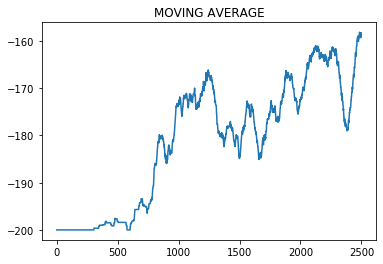

In [55]:
plot_running_avg(np.array(total_rewards))

### RBF NNs & Q-Learning

#### Functions

In [147]:
def sampler_observations(env, sample_size, standardize=True):
    '''
    Generates a sample of states of an environement or game
    '''
    sample = np.array([env.observation_space.sample() for idx in range(sample_size)])
    if standardize:
        scaler = StandardScaler()
        scaled_sample = scaler.fit_transform(sample)
        dic = {'SCALER': scaler, 'SAMPLE': sample, 'SCALED_SAMPLE': scaled_sample}
    else:
        dic = {'SCALER': scaler, 'SAMPLE': sample}
    print('GENERATED DATA WITH SHAPE', sample.shape)
    return dic

In [165]:
def rbf_featurizer(data, gammas, num_components):
    '''
    Generates a rbf featurizer for different gammas (variances) and fit data with it
    '''
    features = []
    for idx, g in enumerate(gammas):
        rbf_name = 'RBF-' + str(idx)
        s = RBFSampler(gamma=g, n_components=num_components)
        rbf = (rbf_name, s)
        features.append(rbf)
    featurizer = FeatureUnion(features)
    t_features = featurizer.fit_transform(data)
    dic = {'FEATURIZER': featurizer, 'TRANSFORM_FEATURES': t_features}
    return dic

In [311]:
def init_models(env, featurizer, scaler, n_actions=None,l_r=0.01):
    models = []
    if n_actions==None:
        n_actions = env.action_space.n
    
    for i in range(n_actions):
        model = SGDRegressor(learning_rate=l_r)
        state_scaled = scaler.transform([env.reset()])
        state_feature = featurizer.transform(state_scaled)
        model.partial_fit(state_feature, [0])
        models.append(model)
    return models

def predict(state, featurizer, scaler, models):
    state_scaled = scaler.transform([state])
    state_feature = featurizer.transform(state_scaled)
    #assert(len(state_feature.shape) == 2)
    predictions = np.array([m.predict(state_feature)[0] for m in models])
    return predictions

def update(state, idx_a, g, featurizer, scaler, models):
    state_scaled = scaler.transform([state])
    state_feature = featurizer.transform(state_scaled)
    #assert(len(state_feature.shape) == 2)
    models[idx_a].partial_fit(state_feature, [g])
    
def sample_action(env, state, featurizer, scaler, models, eps, actions=None):
    if sum(actions == None) != 0:
        actions = np.array(list(range(0,env.action_space.n)))
    if np.random.random() < eps:
        idx = np.random.choice(len(actions), size=1)[0]
        return [actions[idx], idx]
    else:
        predictions = predict(state, featurizer, scaler, models)
        
        return [actions[np.argmax(predictions)], np.argmax(predictions)]

In [335]:
def play_game(env, models, featurizer, scaler, eps, gamma, n_actions=None, actions=None, updt=True):
    obs = env.reset()
    done = False
    steps = 0
    total_reward = 0
    pre_ac = None
    
    while not done:
        ac, idx_ac = sample_action(env=env, state=obs, featurizer=featurizer, scaler=scaler,
                                   models=models, eps=eps, actions=actions)
        pre_obs = obs.copy()
        obs, rew, done, _ = my_env.step(action=ac)
        total_reward += rew
        
        
        pre_pos, pre_vel = pre_obs
        pos, vel = obs
        
        #Update the model
        if updt:
            g = rew + gamma*np.max(predict(state=obs, featurizer=featurizer, scaler=scaler, models=models))
            update(state=pre_obs, idx_a=idx_ac, g=g, featurizer=featurizer, scaler=scaler, models=models)
        
        steps += 1
        pre_ac = ac
    return total_reward

In [349]:
#ITERATE AND LEARN
comparision_avg_reward = -109

total_rewards = []
l_r = 'invscaling'

#GENERATE SAMPLES
iterations = 10000
size = 50000
sample = sampler_observations(env=my_env, sample_size=size)
actions = np.array([0,2])
printer = 100

sample_data = sample['SCALED_SAMPLE']
scaler = sample['SCALER']
featurization = rbf_featurizer(data=sample_data, gammas=[0.5, 0.4, 0.3, 0.2, 0.1, 0.05],
                               num_components=75)
featurizer = featurization['FEATURIZER']
models = init_models(env=my_env, featurizer=featurizer, scaler=scaler, l_r=l_r, n_actions=len(actions))

'''
ITERATE AND LEARN USING RBF NN'S
'''
print('READY TO LEARN---')
for i in range(iterations):
    eps = 0.1*(0.9**(i+1))
    gamma = 0.99
    total_reward = play_game(env=my_env, models=models, featurizer=featurizer, scaler=scaler,
                             eps=eps, gamma=gamma, n_actions=len(actions), actions=actions)
    total_rewards.append(total_reward)
    
    if (i+1) % printer == 0:
        print(i+1, 'ITERATION -', np.mean(total_rewards[i-(printer-1):i+1]),
              str(printer) + '-MOVING AVG REWARD')
        if np.mean(total_rewards[i-(printer-1):i+1]) > (comparision_avg_reward):
            break

GENERATED DATA WITH SHAPE (50000, 2)
READY TO LEARN---
100 ITERATION - -197.65 100-MOVING AVG REWARD
200 ITERATION - -153.51 100-MOVING AVG REWARD
300 ITERATION - -119.27 100-MOVING AVG REWARD
400 ITERATION - -118.34 100-MOVING AVG REWARD
500 ITERATION - -111.11 100-MOVING AVG REWARD
600 ITERATION - -114.2 100-MOVING AVG REWARD
700 ITERATION - -107.26 100-MOVING AVG REWARD


In [351]:
#ITERATE AND CHECK
total_rewards = []
printer = 25
eps = -1

#GENERATE SAMPLES
iterations = 100
'''
ITERATE AND CHECK USING RBF NN'S
'''
print('READY TO CHECK---')
for i in range(iterations):
    total_reward = play_game(env=my_env, models=models, featurizer=featurizer, scaler=scaler,
                             eps=eps, gamma=gamma, n_actions=len(actions), actions=actions, updt=False)
    total_rewards.append(total_reward)
    
    if (i+1) % printer == 0:
        print('ITERATION', i+1)

print('RESULTS---')
print('AVERAGE OF REWARD:', np.round(np.mean(total_rewards), 2))
print('STD OF REWARD:', np.round(np.std(total_rewards), 2))
print('MINIMUM OF REWARD:', np.round(np.min(total_rewards), 2))
print('MAXIMUM OF REWARD:', np.round(np.max(total_rewards), 2))

READY TO CHECK---
ITERATION 25
ITERATION 50
ITERATION 75
ITERATION 100
RESULTS---
AVERAGE OF REWARD: -104.57
STD OF REWARD: 12.54
MINIMUM OF REWARD: -117.0
MAXIMUM OF REWARD: -83.0


Amazing results produced by our __RBF Neural Network__ with a pretty good avergare reward (compared with our best intelligent system).